In [1]:
import numpy as np
import pandas as pd
from gtda.mapper import (
    CubicalCover,
    OneDimensionalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)
from gtda.mapper.cluster import ParallelClustering
from gtda.mapper import Eccentricity,Entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, OPTICS

In [2]:
import openpyxl
xlsx = pd.ExcelFile('41591_2020_897_MOESM3_ESM.xlsx')
df = pd.read_excel(xlsx, '(B) Figure 1B')

In [5]:
df = df.rename({'Patient ID' : 'ID','IgG S/CO': 'IgG (S/CO)', 'IgM S/CO': 'IgM (S/CO)'}, axis=1)

In [6]:
df1 = df[['ID','Days after symptoms onset', 'IgG (S/CO)', 'IgM (S/CO)', 'Severity']]

In [8]:
df1[df1['Severity']==1].drop(['Severity'],axis=1).head()

,ID,Days after symptoms onset,IgG (S/CO),IgM (S/CO)
1,2,11,12.978,8.157
2,3,19,71.973,25.865
4,5,14,21.945,118.031
11,12,16,8.720,3.012
14,15,17,4.258,24.242


In [9]:
is_sever = df1['Severity'] == 1
isnt_sever = df1['Severity'] == 0
data_sever = df1[is_sever].drop(['Severity', 'ID'],axis=1)
data_not_sever = df1[isnt_sever].drop(['Severity', 'ID'],axis=1)

In [10]:
len(data_sever),len(data_not_sever)

(39, 223)

In [11]:
data_sever.head()

,Days after symptoms onset,IgG (S/CO),IgM (S/CO)
1,11,12.978,8.157
2,19,71.973,25.865
4,14,21.945,118.031
11,16,8.720,3.012
14,17,4.258,24.242


# Severe

## Filter: PCA*

In [12]:
filter_func =PCA(n_components=1)
cover = CubicalCover(n_intervals=46, overlap_frac=0.8) 
#100,0.9; 210,0.95; 500,0.98 are is like 46,0.8


clusterer = DBSCAN(eps = 0.01,metric='cosine')
#clusterer = AgglomerativeClustering(n_clusters=3,linkage='single')


n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [13]:
node_scale = 20
fig = plot_interactive_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    color_data = data_sever
                                   ),
fig[0]

In [14]:
graph = pipe.fit_transform(data_sever)

node_id = 15
node_elements = graph.vs["node_elements"]

print(f"""
Node ID: {node_id}
Node elements: {node_elements[node_id]}
Data points: {data_sever.iloc[node_elements[node_id]]}
""")


Node ID: 15
Node elements: [ 3  5  7 14 19 21 23 26]
Data points:      Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
11                          16       8.720       3.012
19                          14       4.095       4.123
33                          16       9.253      11.941
103                         17      14.238       2.216
147                         21      77.231       2.870
149                         15      29.264      82.047
153                         19      60.968      14.376
161                         16       7.014       2.501



## Filter: Eccentricity**

In [15]:
filter_func = Eccentricity(exponent = 1)

cover = OneDimensionalCover(n_intervals=82, overlap_frac=0.95, kind = "balanced")#70,0.9


clusterer = DBSCAN(eps = 0.1,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

##############Checar "balanced" 64, 0.94

In [16]:
node_scale = 30
fig = plot_interactive_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=3, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = data_sever),
fig[0]

In [17]:
graph = pipe.fit_transform(data_sever)

In [18]:
def Nodes(nodes, data_sever,pipe):
    graph = pipe.fit_transform(data_sever)
    for i in nodes:
        node_id = i
        node_elements = graph.vs["node_elements"]
        print(f"""
        Node ID: {node_id}
        Node elements: {node_elements[node_id]}
        Data points: \n{data_sever.iloc[node_elements[node_id]]}
        """)

In [19]:
Nodes([10,11,12,13,14], data_sever, pipe)


        Node ID: 10
        Node elements: [ 1 24 30]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
2                           19      71.973      25.865
155                         10      72.264       1.787
187                         12      90.705       8.982
        

        Node ID: 11
        Node elements: [ 1 24 30]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
2                           19      71.973      25.865
155                         10      72.264       1.787
187                         12      90.705       8.982
        

        Node ID: 12
        Node elements: [ 1 19 24 30]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
2                           19      71.973      25.865
147                         21      77.231       2.870
155                         10      72.264       1.787
187                         12      90.705       8.982
        

        Node ID: 13
   

In [21]:
filter_func = Eccentricity(exponent = 1)

cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.97,kind='balanced')


clusterer = DBSCAN(eps = 0.1,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    contract_nodes=True,
    verbose=False,
    n_jobs=n_jobs,
)




############## "balanced" 64, 0.94

In [22]:
node_scale = 30
fig = plot_interactive_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=None,
                                    color_data = data_sever),
fig[0]

In [23]:
graph = pipe.fit_transform(data_sever)

In [24]:
def Nodes(nodes, data_sever ,pipe):
    graph = pipe.fit_transform(data_sever)
    for i in nodes:
        node_id = i
        node_elements = graph.vs["node_elements"]
        print(f"""
        Node ID: {node_id}
        Node elements: {node_elements[node_id]}
        Data points: \n{data_sever.iloc[node_elements[node_id]]}
        """)

In [25]:
Nodes([0,1,9,7,10,11], data_sever, pipe)


        Node ID: 0
        Node elements: [ 0  3  5  6  7 13 14 22 26 29]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
1                           11      12.978       8.157
11                          16       8.720       3.012
19                          14       4.095       4.123
32                          10      42.440       0.813
33                          16       9.253      11.941
100                         12      27.979       5.048
103                         17      14.238       2.216
152                         12      27.511      20.625
161                         16       7.014       2.501
185                         16      55.371      17.215
        

        Node ID: 1
        Node elements: [ 0  3  5  6  7 14 22 26 29]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
1                           11      12.978       8.157
11                          16       8.720       3.012
19                          14

In [26]:
Nodes([21], data_sever, pipe)


        Node ID: 21
        Node elements: [12 18 34 36]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
92                           9       0.933       0.482
146                          8       3.091       4.008
237                         19      10.630      23.847
241                         19       4.860       3.188
        


In [27]:
Nodes([20], data_sever, pipe)


        Node ID: 20
        Node elements: [12 15 20]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
92                           9       0.933       0.482
104                         10       2.156       0.178
148                          9       2.171       0.279
        


If we want to create a refinement of covers in order to search persistence features, settle a cover wich intervals are of the same length eases the work. If $M= \max \lbrace f(x): x\in X\rbrace$, $m= \min \lbrace f(x): x\in X\rbrace$, $l$ is the common length of the intervals, $n$ is the number of intervals and $q\in (0,1)$ is the overlapping percentage, then is easy to see that

$$l(n(1-q)+1) = M-m$$

Then, if we want a refinement of covers with percentages $1\%, 4\%, 18\%, 30\%, 90\%$ and $l = 0.3(M-m)$, we can calculate the number of intervals that we need.

In [28]:
percen = np.array([(3*k-7)/(3*k) for k in range(1003,1100) ])

In [29]:
fil = Eccentricity(exponent = 1).fit_transform(data_sever)
M, m = np.max(fil),np.min(fil)
M-m

3804.4280745158276

In [30]:
n = 7/3*1/(1-percen)
len(n)

97

In [31]:
val = np.concatenate((n.reshape(97,1), percen.reshape(97,1)), axis=1)

In [32]:
filter_func = Eccentricity(exponent = 1)

cover = OneDimensionalCover(n_intervals=82, overlap_frac=0.85)#70,0.9


clusterer = DBSCAN(eps = 0.1,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

##############Checar "balanced" 64, 0.94

In [33]:
fig = plot_interactive_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=30,
                                    node_color_statistic=np.mean,
                                    color_data = data_sever),
fig[0]

In [34]:
graph = pipe.fit_transform(data_sever)

In [35]:
def Nodes(nodes, data_sever,pipe):
    graph = pipe.fit_transform(data_sever)
    for i in nodes:
        node_id = i
        node_elements = graph.vs["node_elements"]
        print(f"""
        Node ID: {node_id}
        Node elements: {node_elements[node_id]}
        Data points: \n{data_sever.iloc[node_elements[node_id]]}
        """)

In [36]:
Nodes([27], data_sever, pipe)


        Node ID: 27
        Node elements: [ 9 19 32 35 37]
        Data points: 
     Days after symptoms onset  IgG (S/CO)  IgM (S/CO)
49                           6       0.249       0.430
147                         21      77.231       2.870
194                         12     114.250       3.311
239                         23       7.389      18.280
254                         23      16.735      12.472
        


In [37]:
percen = np.array([(k)/(k+3) for k in range(3,100) ])

In [38]:
fil = Eccentricity(exponent = 1).fit_transform(data_sever)
M, m = np.max(fil),np.min(fil)
M-m

3804.4280745158276

In [39]:
n = (1/0.1 -1)*1/(1-percen)
len(n)

97

In [40]:
val = np.concatenate((n.reshape(97,1), percen.reshape(97,1)), axis=1)

## Another experiment

In [41]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')

cover = OneDimensionalCover(n_intervals=60, overlap_frac=0.9,kind='balanced')


clusterer = DBSCAN(eps = 0.01,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    contract_nodes=True,
    verbose=False,
    n_jobs=n_jobs,
)




##############Checar "balanced" 64, 0.94

In [42]:
node_scale = 25
fig = plot_interactive_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = data_sever),
fig[0]

In [43]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')

cover = OneDimensionalCover(n_intervals=60, overlap_frac=0.9,kind='balanced')


clusterer = DBSCAN(eps = 0.01,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    contract_nodes=True,
    verbose=False,
    n_jobs=n_jobs,
)

node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = data_sever[['IgG (S/CO)']],
                                    plotly_params = {"layout" : {"font_size":14}})
fig.write_image("images/sev_ig.pdf")

In [44]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')

cover = OneDimensionalCover(n_intervals=60, overlap_frac=0.9,kind='balanced')


clusterer = DBSCAN(eps = 0.01,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    contract_nodes=True,
    verbose=False,
    n_jobs=n_jobs,
)

node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = data_sever[['IgM (S/CO)']],
                                    plotly_params = {"layout" : {"font_size":14}})
fig.write_image("images/sev_im.pdf")

In [45]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')

cover = OneDimensionalCover(n_intervals=60, overlap_frac=0.9,kind='balanced')


clusterer = DBSCAN(eps = 0.01,metric='cosine',min_samples=3)

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    contract_nodes=True,
    verbose=False,
    n_jobs=n_jobs,
)

node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    data_sever, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = data_sever[['Days after symptoms onset']],
                                    plotly_params = {"layout" : {"font_size":14}})
fig.write_image("images/sev_d.pdf")

In [46]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

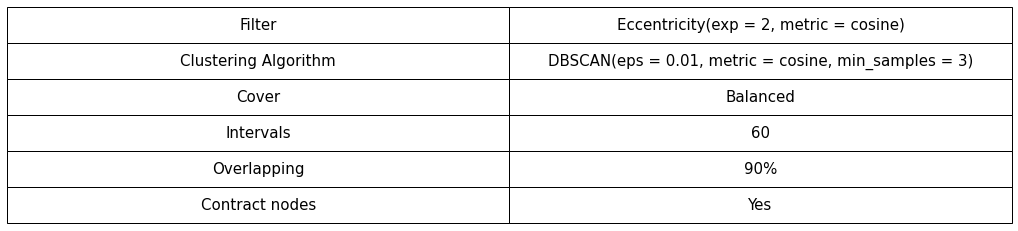

In [48]:
meta_table = plt.table(cellText=[['Filter', 'Eccentricity(exp = 2, metric = cosine)'], 
     ['Clustering Algorithm', 'DBSCAN(eps = 0.01, metric = cosine, min_samples = 3)'],
     ['Cover', 'Balanced'],
     ['Intervals', '60'],
     ['Overlapping', '90%'],
     ['Contract nodes', 'Yes']],
         cellLoc = 'center',
         loc = 'center',
         colLoc = 'center',
         rowLoc = 'center',
         #cellColours = [['#8DD4CD','w'],['#8DD4CD','w'],['#8DD4CD','w'],['#8DD4CD','w'],['#8DD4CD','w'],['#8DD4CD','w']],
         edges = 'closed',
         #colWidths = [0.05,0.20,0.10,0.10,0.10]
         )
plt.axis('off')
meta_table.auto_set_font_size(False)
meta_table.set_fontsize(15)
meta_table.scale(3,3)
meta_fig = meta_table.figure

pp = PdfPages("tabgen3.pdf")
pp.savefig(meta_fig, bbox_inches='tight')
pp.close()